In [1]:
#import the following packages to help run the code
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import array as arr
import pandas as pd
from scipy.optimize import Bounds
import scipy.optimize as spo
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
%matplotlib inline

In [2]:
#User should enter the number of multistarts
multistart=2
#Reads the csv file of the data in the example format. User should change the path for filename 
filename=r'C:\Users\Deepraj\Documents\PaperCode\Papercode\Papercode_v11\Pythonestimator\threenodeexample.csv'
Ydata = pd.read_csv(filename)

In [3]:
# This code generates simulations for the no perturbation case for a given set of parameters 'r'
def dYdx(x,Y,r):
    y1, y2, y3 = Y
    S1=-(r[1]* Ydata['Y1'][0]+r[2]* Ydata['Y2'][0]+r[3]* Ydata['Y3'][0]);
    S2=-(r[5]* Ydata['Y1'][0]+r[6]* Ydata['Y2'][0]+r[7]* Ydata['Y3'][0]);
    S3=-(r[9]* Ydata['Y1'][0]+r[10]* Ydata['Y2'][0]+r[11]* Ydata['Y3'][0]);
    dydx=[S1+r[0]+r[1]*y1+r[2]*y2+r[3]*y3,
          S2+r[4]+r[5]*y1+r[6]*y2+r[7]*y3,
          S3+r[8]+r[9]*y1+r[10]*y2+r[11]*y3]
    return dydx


In [4]:
# This code generates simulations for the case of perturbation of the first node for a given set of parameters 'r'
def dYP1dx(x,YP1,r):
    y2,y3 = YP1
    S2=-(r[5]* Ydata['Y1'][0]+r[6]* Ydata['Y2'][0]+r[7]* Ydata['Y3'][0]);
    S3=-(r[9]* Ydata['Y1'][0]+r[10]* Ydata['Y2'][0]+r[11]* Ydata['Y3'][0]);
    dydx=[S2+r[4]+r[5]*f1(x)+r[6]*y2+r[7]*y3,
          S3+r[8]+r[9]*f1(x)+r[10]*y2+r[11]*y3]
    return dydx


In [5]:
# This code generates simulations for the case of perturbation of the second node for a given set of parameters 'r'

def dYP2dx(x,YP2,r):
    y1,y3 = YP2
    S1=-(r[1]* Ydata['Y1'][0]+r[2]* Ydata['Y2'][0]+r[3]* Ydata['Y3'][0]);
    S3=-(r[9]* Ydata['Y1'][0]+r[10]* Ydata['Y2'][0]+r[11]* Ydata['Y3'][0]);
    dydx=[S1+r[0]+r[1]*y1+r[2]*f2(x)+r[3]*y3,
          S3+r[8]+r[9]*y1+r[10]*f2(x)+r[11]*y3]
    return dydx


In [6]:
# This code generates simulations for the case of perturbation of the third node for a given set of parameters 'r'
def dYP3dx(x,YP3,r):
    y1,y2 = YP3
    S1=-(r[1]* Ydata['Y1'][0]+r[2]* Ydata['Y2'][0]+r[3]* Ydata['Y3'][0]);
    S2=-(r[5]* Ydata['Y1'][0]+r[6]* Ydata['Y2'][0]+r[7]* Ydata['Y3'][0]);
    dydx=[S1+r[0]+r[1]*y1+r[2]*y2+r[3]*f3(x),
          S2+r[4]+r[5]*y1+r[6]*y2+r[7]*f3(x)]
    return dydx

In [7]:
# This node compares the sum of squared errors for the actuak data vs generated data for a given set of parameters 'r'
def minfunc(r):
    gY = odeint(dYdx, y0=Y_0, t=T, args=(r,), tfirst=True)
    gYP1 = odeint(dYP1dx, y0=YP1_0, args=(r,), t=T, tfirst=True)
    gYP2 = odeint(dYP2dx, y0=YP2_0, args=(r,), t=T, tfirst=True)
    gYP3 = odeint(dYP3dx, y0=YP3_0, args=(r,), t=T, tfirst=True)
    SSE0=np.sum(np.sum((Ydata[['Y1','Y2','Y3']]-gY)**2))
    SSE1=np.sum(np.sum(( Ydata[['YP1_2','YP1_3']]-(gYP1))**2))
    SSE2=np.sum(np.sum(( Ydata[['YP2_1','YP2_3']]-(gYP2))**2))
    SSE3=np.sum(np.sum(( Ydata[['YP3_1','YP3_2']]-(gYP3))**2))
    SSE=SSE0+SSE1+SSE2+SSE3    
    return SSE

In [8]:
#param1 is the set of parameters without the basal production terms
param1= [ [0]*12 for i in range(multistart)]
#param2 is the set of all parameters including the basal production terms
param2= [ [0]*15 for i in range(multistart)]
#pred_SSE is the sum of squared errors for each multistart. If a multistart run is unsuccessful, it returns a value of 1000
pred_SSE= [ [1000] for i in range(multistart)]

T = Ydata['T']
# generating polyfit of perturbation data. 
#User can change the order of the polynomial if desired. In this case, the order is 3. 
p1=np.polyfit(T, Ydata['YP1_1'], 4, rcond=None, full=False, w=None, cov=False)
p2=np.polyfit(T, Ydata['YP2_2'], 4, rcond=None, full=False, w=None, cov=False)
p3=np.polyfit(T, Ydata['YP3_3'], 4, rcond=None, full=False, w=None, cov=False)

f1 = np.poly1d(p1)
f2 = np.poly1d(p2)
f3 = np.poly1d(p3)

# Setting initial conditions
Y_0 = (Ydata['Y1'][0],Ydata['Y2'][0],Ydata['Y3'][0])
YP1_0 = (Ydata['YP1_2'][0],Ydata['YP1_3'][0])
YP2_0 = (Ydata['YP2_1'][0],Ydata['YP2_3'][0])
YP3_0 = (Ydata['YP3_1'][0],Ydata['YP3_2'][0])

# User can change bounds. We found these work well
bounds = Bounds([-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10], [10,10,10,10,10,10,10,10,10,10,10,10])

for i in range(multistart):
    r=random.rand(12)
    #the following code tries to find the set of parameters with the least SSE, within the bounds
    result=spo.minimize(minfunc,r,method='trust-constr',bounds=bounds,options={'xtol':0.0001,'gtol': 0.0001})
    if result.success==True:
        print(result.x)
        param1[i]=list(result.x)
        param2[i][0]=-(param1[i][1]* Ydata['Y1'][0]+param1[i][2]* Ydata['Y2'][0]+param1[i][3]* Ydata['Y3'][0])
        param2[i][1:5]=param1[i][0:4]
        param2[i][5]=-(param1[i][5]* Ydata['Y1'][0]+param1[i][6]* Ydata['Y2'][0]+param1[i][7]* Ydata['Y3'][0])
        param2[i][6:10]=param1[i][4:8]
        param2[i][10]=-(param1[i][5]* Ydata['Y1'][0]+param1[i][6]* Ydata['Y2'][0]+param1[i][7]* Ydata['Y3'][0])
        param2[i][11:15]=param1[i][8:12]
        pred_SSE[i]=(result.fun)
    else:
        r=random.rand(12)
        result=spo.minimize(minfunc,r,method='trust-constr',bounds=bounds, options={'xtol':0.0001,'gtol': 0.0001},hess = lambda x: np.zeros((12, 12)))
        param1[i]=list(result.x)
        param2[i][0]=-(param1[i][1]* Ydata['Y1'][0]+param1[i][2]* Ydata['Y2'][0]+param1[i][3]* Ydata['Y3'][0])
        param2[i][1:5]=param1[i][0:4]
        param2[i][5]=-(param1[i][5]* Ydata['Y1'][0]+param1[i][6]* Ydata['Y2'][0]+param1[i][7]* Ydata['Y3'][0])
        param2[i][6:10]=param1[i][4:8]
        param2[i][10]=-(param1[i][5]* Ydata['Y1'][0]+param1[i][6]* Ydata['Y2'][0]+param1[i][7]* Ydata['Y3'][0])
        param2[i][11:15]=param1[i][8:12]
        pred_SSE[i]=(result.fun)


[ 1.856786   -1.51863919 -1.29580671 -0.12840403  1.39109067 -0.10162102
 -1.38090824 -1.6619988   1.29246025 -0.71586105  0.53171141 -1.70647283]


C:\Users\Deepraj\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[ 1.8569005  -1.51873867 -1.29589406 -0.12841987  1.39111234 -0.10162924
 -1.3809302  -1.66201395  1.2929088  -0.71611228  0.53186556 -1.70707761]


In [9]:
pred_SSE

[9.903550573320985e-09, 5.5806418079441024e-09]

In [10]:
# the parameters in param2=[S1b,S1ext,F11,F12,F13,S2b,S2ext,F21,F22,F33,S3b,S3ext,F31,F32,F33]
param2

[[1.7515209121752684,
  1.856785995664219,
  -1.5186391943246533,
  -1.2958067115053993,
  -0.12840403481901122,
  1.6218588654313884,
  1.3910906714455595,
  -0.10162101854477112,
  -1.3809082363494456,
  -1.66199879711407,
  1.6218588654313884,
  1.2924602475830276,
  -0.7158610527821917,
  0.5317114085978479,
  -1.706472825408004],
 [1.7516412063893825,
  1.8569005016435156,
  -1.5187386735394377,
  -1.2958940598594386,
  -0.12841987298298713,
  1.6218828053145276,
  1.391112337296301,
  -0.1016292395078721,
  -1.3809302037604705,
  -1.6620139485143883,
  1.6218828053145276,
  1.2929087978531404,
  -0.7161122819334318,
  0.5318655589263437,
  -1.7070776111581478]]

In [11]:
#find the index of the set of parameters with minimum sum of squared errors
minpos=pred_SSE.index(min(pred_SSE))
minpos

1

In [12]:
# generate data with a the set of parameters with minimum sum of squared errors
T_pred=np.linspace(0,Ydata['T'].iloc[-1],10*len(Ydata['T']))
Y_ss = odeint(dYdx, y0=Y_0, t=T_pred, args=(param1[minpos],), tfirst=True)
YP1_ss = odeint(dYP1dx, y0=YP1_0, t=T_pred, args=(param1[minpos],), tfirst=True)
YP2_ss = odeint(dYP2dx, y0=YP2_0, t=T_pred, args=(param1[minpos],), tfirst=True)
YP3_ss = odeint(dYP3dx, y0=YP3_0, t=T_pred, args=(param1[minpos],), tfirst=True)
Y_pred=pd.DataFrame(Y_ss)
YP1_pred=pd.DataFrame(YP1_ss)
YP2_pred=pd.DataFrame(YP2_ss)
YP3_pred=pd.DataFrame(YP3_ss)

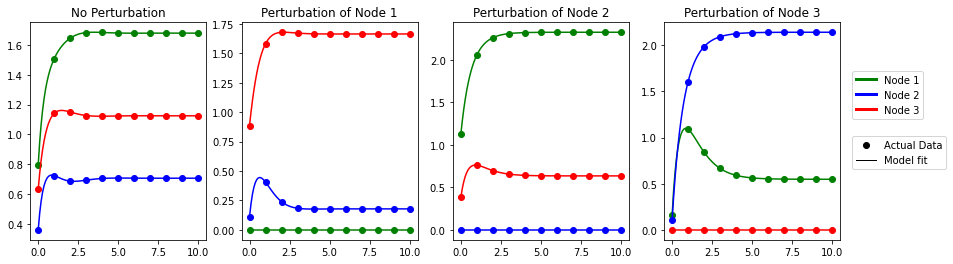

In [13]:
# plot actual data vs model fits
plt.figure()
plt.subplot(1, 4, 1)
plt.plot(T,Ydata['Y1'],'go')
plt.plot(T_pred,Y_pred[0],'g')
plt.plot(T,Ydata['Y2'],'bo')
plt.plot(T_pred,Y_pred[1],'b')
plt.plot(T,Ydata['Y3'],'ro')
plt.plot(T_pred,Y_pred[2],'r')
plt.title('No Perturbation')


plt.subplot(1, 4, 2)
plt.plot(T,Ydata['YP1_1'],'go')
plt.plot(T,Ydata['YP1_1'],'g')
plt.plot(T,Ydata['YP1_2'],'bo')
plt.plot(T_pred,YP1_pred[0],'b')
plt.plot(T,Ydata['YP1_3'],'ro')
plt.plot(T_pred,YP1_pred[1],'r')
plt.title('Perturbation of Node 1')

plt.subplot(1, 4, 3)
plt.plot(T,Ydata['YP2_1'],'go')
plt.plot(T_pred,YP2_pred[0],'g')
plt.plot(T,Ydata['YP2_2'],'bo')
plt.plot(T,Ydata['YP2_2'],'b')
plt.plot(T,Ydata['YP2_3'],'ro')
plt.plot(T_pred,YP2_pred[1],'r')
plt.title('Perturbation of Node 2')
custom_lines = [Line2D([0], [0], color='k', marker='o', linestyle='None'),
                Line2D([0], [0], color='k', lw=1)]
plt.legend(custom_lines, ['Actual Data', 'Model fit'],bbox_to_anchor =(2.83, 0.5))


plt.subplot(1, 4, 4)
plt.plot(T,Ydata['YP3_1'],'go')
plt.plot(T_pred,YP3_pred[0],'g')
plt.plot(T,Ydata['YP3_2'],'bo')
plt.plot(T_pred,YP3_pred[1],'b')
plt.plot(T,Ydata['YP3_3'],'ro')
plt.plot(T,Ydata['YP3_3'],'r')
plt.title('Perturbation of Node 3')
custom_lines = [Line2D([0], [0], color='g', lw=3),
                Line2D([0], [0], color='b', lw=3),
                Line2D([0], [0], color='r', lw=3)]
plt.legend(custom_lines, ['Node 1', 'Node 2', 'Node 3'],bbox_to_anchor =(1.5, 0.8))
plt.subplots_adjust(right=2)
